# InfluxDB

In [41]:
!pip install influxdb-client

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.tttech.com/api/pypi/infrastructure.pypi/simple

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [42]:
!pip3 install --upgrade influxdb-client

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.tttech.com/api/pypi/infrastructure.pypi/simple

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [43]:
from influxdb_client   import InfluxDBClient, BucketRetentionRules,WritePrecision
import influxdb_client

In [44]:
import random

In [45]:
import time

In [46]:
import pandas as pd

## Create a Client Object

In [47]:
client = InfluxDBClient(url="http://localhost:8086", token= "my_password", org="primary")
print(client.__dict__)

{'url': 'http://localhost:8086', 'token': 'my_password', 'org': 'primary', 'default_tags': None, 'conf': <influxdb_client.client._base._Configuration object at 0x7fc3a5bf1e50>, 'auth_header_name': 'Authorization', 'auth_header_value': 'Token my_password', 'retries': False, 'profilers': None, 'api_client': <influxdb_client._sync.api_client.ApiClient object at 0x7fc3c3f65cd0>}


In [48]:
def myprint(table):
    for table in tables:
        print(table)
        for row in table.records:
            print (row.values)

# Bucket

In [49]:
bucket_api=client.buckets_api() # get the bucket api object which is used to create and delete buckets


In [ ]:
bucket_api.create_bucket(
    bucket_name="myFirstBucket",
    org_id="primary",
    retention_rules=[BucketRetentionRules(every_seconds=60 * 60)],
)  # create bucket with retention rule of 1 hour


Minimum retention time is 1h!

**Cross Check now in the User Interface**

# Write Data

In [50]:
write_api = client.write_api() # Initialize the write api object

A bucket is a named location where time series data is stored. All buckets have a retention period, a duration of time that each data point persists. InfluxDB drops all points with timestamps older than the bucket’s retention period. A bucket belongs to an organization.

Syntax:

```<measurement>[,<tag_key>=<tag_value>[,<tag_key>=<tag_value>]] <field_key>=<field_value>[,<field_key>=<field_value>] [<timestamp>]```

In [51]:
write_api.write(
    "myFirstBucket", "primary", ["myMeasurement,location=coyote_creek water_level=11.4"]
)  # bucket, organization, measurement: h2o_feet,  location: coyote_creek

# Representing data:

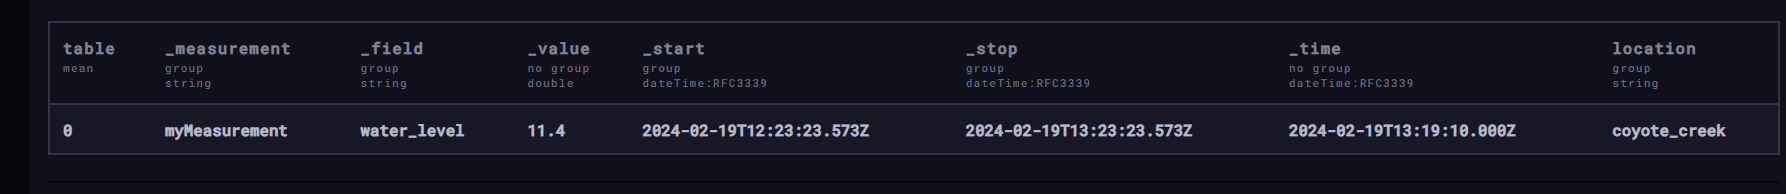

measurement: h2o_feet

location: coyote_creek

field: water_level

Add multiple filed by using `,`

**What is a tag?**

In [52]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,mytag=a_tag_value temperature=2"])  #send data with tag

In [53]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,mytag=a_tag_value temperature=12"]) #send data with tag

Attention: if sent too fast, they are aggregated!

Create a loop for publishing multiple data-points

In [54]:
for i in range(1,10):
    write_api.write("myFirstBucket", "primary", ["robotsensor,location=robotcell temperature={0},humidity={1}".format(random.random()*10,random.random())])
    time.sleep(1)

This is already hard to read. So the api provides a build-pattern mechanism.

In [55]:
p = influxdb_client.Point("robotsensor").tag("location", "robotcell").tag("qos", "2").field("temperature", 20.)
write_api.write(bucket="myFirstBucket", org="primary", record=p)

Fields are data and tags are metadata

## Query

In [56]:
query_api =client.query_api()

In [57]:
tables=query_api.query('from(bucket:"myFirstBucket") |> range(start: -10m)')  #last 10 minutes

Here, we get all fields!

In [58]:
for table in tables:
    print(table)
    for row in table.records:
        print (row.values)

FluxTable() columns: 9, records: 1
{'result': '_result', 'table': 0, '_start': datetime.datetime(2024, 2, 19, 13, 55, 32, 127913, tzinfo=tzutc()), '_stop': datetime.datetime(2024, 2, 19, 14, 5, 32, 127913, tzinfo=tzutc()), '_time': datetime.datetime(2024, 2, 19, 13, 58, 18, 47591, tzinfo=tzutc()), '_value': 9.0, '_field': 'temperature', '_measurement': 'myMeasurement', 'location': 'coyote_creek'}
FluxTable() columns: 9, records: 5
{'result': '_result', 'table': 1, '_start': datetime.datetime(2024, 2, 19, 13, 55, 32, 127913, tzinfo=tzutc()), '_stop': datetime.datetime(2024, 2, 19, 14, 5, 32, 127913, tzinfo=tzutc()), '_time': datetime.datetime(2024, 2, 19, 13, 58, 18, 33000, tzinfo=tzutc()), '_value': 4.0, '_field': 'water_level', '_measurement': 'myMeasurement', 'location': 'coyote_creek'}
{'result': '_result', 'table': 1, '_start': datetime.datetime(2024, 2, 19, 13, 55, 32, 127913, tzinfo=tzutc()), '_stop': datetime.datetime(2024, 2, 19, 14, 5, 32, 127913, tzinfo=tzutc()), '_time': dat

**Might be hard to read: convert that to a pandas**

In [59]:
query_api.query_data_frame('from(bucket:"myFirstBucket") |> range(start: -10m)')[0]  #last 10 minutes

# Result is a pandas dataframe

/home/bobek/.local/lib/python3.11/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    from(bucket:"myFirstBucket") |> range(start: -10m) |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https://docs.influxdata.com/flux/latest/stdlib/influxdata/influxdb/schema/fieldsascols/

  warnings.warn(message, MissingPivotFunction)


,result,table,_start,_stop,_time,_value,_field,_measurement,location
0,_result,0,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:18.047591+00:00,9.0,temperature,myMeasurement,coyote_creek
1,_result,1,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:18.033000+00:00,4.0,water_level,myMeasurement,coyote_creek
2,_result,1,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:18.047591+00:00,3.0,water_level,myMeasurement,coyote_creek
3,_result,1,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:43.304300+00:00,4.0,water_level,myMeasurement,coyote_creek
4,_result,1,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:45.319180+00:00,4.0,water_level,myMeasurement,coyote_creek
5,_result,1,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 14:05:23.922605+00:00,11.4,water_level,myMeasurement,coyote_creek
6,_result,2,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:43.304300+00:00,2.0,water_level,myMeasurement,other
7,_result,2,2024-02-19 13:55:32.172354+00:00,2024-02-19 14:05:32.172354+00:00,2024-02-19 13:58:45.319180+00:00,2.0,water_level,myMeasurement,other


In [60]:
import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

We get a warning, that the representation might not be optimal and pivot should be used.

For the examples discussed here, we will stick to the the current setup!

https://docs.influxdata.com/flux/v0.x/stdlib/universe/pivot/


## Task

Publish to a new measurement `robot` two fields `joint1` and `joint2` with arbitrary values.

In [61]:
# Create a new measurement called robot with two fields `joint1` and `joint2` with arbitrary values.
write_api.write("myFirstBucket", "primary", ["robot,joint=joint1 value=1.0"])
write_api.write("myFirstBucket", "primary", ["robot,joint=joint2 value=2.0"])

# VErify the data
"""
q = '''
from(bucket: stringParam)
|> range(start: -225m, stop: now())
|> filter(fn: (r) => r._measurement == "myMeasurement")
'''

p = {
"stringParam": "myFirstBucket",
}
"""

q = '''
from(bucket: "myFirstBucket")
|> range(start: -225m, stop: now())
|> filter(fn: (r) => r._measurement == "robot")
'''

query_api.query_data_frame(q)


,result,table,_start,_stop,_time,_value,_field,_measurement,joint
0,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:49:08.012741+00:00,1.0,value,robot,joint1
1,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:49:29.229934+00:00,1.0,value,robot,joint1
2,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:49:38.326438+00:00,1.0,value,robot,joint1
3,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:49:52.486297+00:00,1.0,value,robot,joint1
4,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:50:23.840579+00:00,1.0,value,robot,joint1
5,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:50:50.129955+00:00,1.0,value,robot,joint1
6,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:53:17.746201+00:00,1.0,value,robot,joint1
7,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:55:45.389527+00:00,1.0,value,robot,joint1
8,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:55:51.448242+00:00,1.0,value,robot,joint1
9,_result,0,2024-02-19 10:20:32.247697+00:00,2024-02-19 14:05:32.247697+00:00,2024-02-19 13:55:52.457997+00:00,1.0,value,robot,joint1


## Queries

Often, we want to make a query more `re-useable` and so we can distinguish between params and values!

In [62]:
q = '''
    from(bucket: stringParam)
      |> range(start: -225m, stop: now())
      |> filter(fn: (r) => r._measurement == "myMeasurement")
'''

p = {
    "stringParam": "myFirstBucket",
}



In [63]:
result = query_api.query_data_frame(query=q, params=p)

In [64]:
result[0]

,result,table,_start,_stop,_time,_value,_field,_measurement,location
0,_result,0,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:58:18.047591+00:00,9.0,temperature,myMeasurement,coyote_creek
1,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:19:02.350048+00:00,11.4,water_level,myMeasurement,coyote_creek
2,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:45:49.006045+00:00,11.4,water_level,myMeasurement,coyote_creek
3,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:46:41.465749+00:00,11.4,water_level,myMeasurement,coyote_creek
4,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:58:18.033000+00:00,4.0,water_level,myMeasurement,coyote_creek
5,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:58:18.047591+00:00,3.0,water_level,myMeasurement,coyote_creek
6,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:58:43.304300+00:00,4.0,water_level,myMeasurement,coyote_creek
7,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:58:45.319180+00:00,4.0,water_level,myMeasurement,coyote_creek
8,_result,1,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 14:05:23.922605+00:00,11.4,water_level,myMeasurement,coyote_creek
9,_result,2,2024-02-19 10:20:32.302294+00:00,2024-02-19 14:05:32.302294+00:00,2024-02-19 13:58:43.304300+00:00,2.0,water_level,myMeasurement,other


The _start and _stop timestamps are the timestamps that corresponds with the range() portion of your query

We see, that if we write multiple messages at exactly the same time, they will be overwritten!

In [65]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek water_level=4"],write_precision=WritePrecision.MS)
time.sleep(0.1)
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek water_level=2"]) 
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek water_level=3,temperature=9"]) 

`For points that have the same measurement name, tag set, and timestamp, InfluxDB creates a union of the old and new field sets`

In [66]:
tables=query_api.query_data_frame('from(bucket:"myFirstBucket") \
                                  |> range(start: -10m)  \
                                  |> filter(fn: (r) => r._measurement == "myMeasurement") \
                                  |> filter(fn: (r) => r.location == "coyote_creek") \
                                  ')  #last 10 minutes

tables

,result,table,_start,_stop,_time,_value,_field,_measurement,location
0,_result,0,2024-02-19 13:55:32.478875+00:00,2024-02-19 14:05:32.478875+00:00,2024-02-19 13:58:18.047591+00:00,9.0,temperature,myMeasurement,coyote_creek
1,_result,1,2024-02-19 13:55:32.478875+00:00,2024-02-19 14:05:32.478875+00:00,2024-02-19 13:58:18.033000+00:00,4.0,water_level,myMeasurement,coyote_creek
2,_result,1,2024-02-19 13:55:32.478875+00:00,2024-02-19 14:05:32.478875+00:00,2024-02-19 13:58:18.047591+00:00,3.0,water_level,myMeasurement,coyote_creek
3,_result,1,2024-02-19 13:55:32.478875+00:00,2024-02-19 14:05:32.478875+00:00,2024-02-19 13:58:43.304300+00:00,4.0,water_level,myMeasurement,coyote_creek
4,_result,1,2024-02-19 13:55:32.478875+00:00,2024-02-19 14:05:32.478875+00:00,2024-02-19 13:58:45.319180+00:00,4.0,water_level,myMeasurement,coyote_creek
5,_result,1,2024-02-19 13:55:32.478875+00:00,2024-02-19 14:05:32.478875+00:00,2024-02-19 14:05:23.922605+00:00,11.4,water_level,myMeasurement,coyote_creek


However, if a tag is different, then we do not have that behaviour!

In [67]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek water_level=4"])
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=other water_level=2"]) 

In [68]:
tables=query_api.query_data_frame('from(bucket:"myFirstBucket") |> range(start: -1m)  \
                                  |> filter(fn: (r) => r._measurement == "myMeasurement") \
                                  ')  #last 10 minutes

tables

[    result  table                           _start  \
 0  _result      0 2024-02-19 14:04:32.556384+00:00   
 
                              _stop                            _time  _value  \
 0 2024-02-19 14:05:32.556384+00:00 2024-02-19 14:05:23.922605+00:00    11.4   
 
         _field   _measurement      location  
 0  water_level  myMeasurement  coyote_creek  ,
     result  table                           _start  \
 0  _result      1 2024-02-19 14:04:32.556384+00:00   
 
                              _stop                            _time  _value  \
 0 2024-02-19 14:05:32.556384+00:00 2024-02-19 14:05:23.922605+00:00    12.0   
 
         _field   _measurement        mytag  
 0  temperature  myMeasurement  a_tag_value  ]

**More Complex Query**

With keep you can limit the number of fields - `keep` is similar to `select` in SQL

In [69]:
tables=query_api.query_data_frame("""
                        from(bucket:"myFirstBucket") 
                        |> range(start: -2135m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        |> keep(columns:["_value"])
                        """)  

tables

,result,table,_value
0,_result,0,9.0
1,_result,0,2.0
2,_result,0,12.0
3,_result,0,2.0
4,_result,0,12.0


In [70]:
tables=query_api.query_data_frame("""
                        from(bucket:"myFirstBucket") 
                        |> range(start: -215m) 
                        |> filter(fn: (r) => r._measurement == "robotsensor")
                        |> filter(fn: (r) => r._field == "temperature")
                        """)  

Joins are also existing!

In [71]:
tables=query_api.query_data_frame("""
                        mymeasure=from(bucket:"myFirstBucket") 
                        |> range(start: -215m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")

                        robotsensor=from(bucket:"myFirstBucket") 
                        |> range(start: -215m) 
                        |> filter(fn: (r) => r._measurement == "robotsensor")
                        |> filter(fn: (r) => r._field == "temperature")
                        
                        
                        join(tables: {mymeasure:mymeasure, robotsensor:robotsensor}, on: ["_field"], method: "inner")
                        """)  

tables[0]

,result,table,_field,_measurement_mymeasure,_measurement_robotsensor,_start_mymeasure,_start_robotsensor,_stop_mymeasure,_stop_robotsensor,_time_mymeasure,_time_robotsensor,_value_mymeasure,_value_robotsensor,location_mymeasure,location_robotsensor
0,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:44.833066+00:00,9.0,0.788418,coyote_creek,robotcell
1,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:45.843293+00:00,9.0,9.566313,coyote_creek,robotcell
2,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:46.853623+00:00,9.0,6.183395,coyote_creek,robotcell
3,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:47.868468+00:00,9.0,9.537182,coyote_creek,robotcell
4,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:48.881303+00:00,9.0,0.276154,coyote_creek,robotcell
5,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:49.893322+00:00,9.0,6.998037,coyote_creek,robotcell
6,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:50.905821+00:00,9.0,9.750953,coyote_creek,robotcell
7,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:51.916254+00:00,9.0,7.897891,coyote_creek,robotcell
8,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:24:52.928134+00:00,9.0,2.895906,coyote_creek,robotcell
9,_result,0,temperature,myMeasurement,robotsensor,2024-02-19 10:30:45.808834+00:00,2024-02-19 10:30:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 14:05:45.808834+00:00,2024-02-19 13:58:18.047591+00:00,2024-02-19 13:46:45.510990+00:00,9.0,4.670486,coyote_creek,robotcell


Filtering for tags is also possible!

In [72]:
tables=query_api.query_data_frame("""
                        from(bucket:"myFirstBucket") 
                        |> range(start: -2135m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r.mytag == "a_tag_value")
                        """)  

tables

,result,table,_start,_stop,_time,_value,_field,_measurement,mytag
0,_result,0,2024-02-18 02:30:49.909124+00:00,2024-02-19 14:05:49.909124+00:00,2024-02-19 13:24:34.725126+00:00,2.0,temperature,myMeasurement,a_tag_value
1,_result,0,2024-02-18 02:30:49.909124+00:00,2024-02-19 14:05:49.909124+00:00,2024-02-19 13:24:35.735725+00:00,12.0,temperature,myMeasurement,a_tag_value
2,_result,0,2024-02-18 02:30:49.909124+00:00,2024-02-19 14:05:49.909124+00:00,2024-02-19 13:46:43.488222+00:00,2.0,temperature,myMeasurement,a_tag_value
3,_result,0,2024-02-18 02:30:49.909124+00:00,2024-02-19 14:05:49.909124+00:00,2024-02-19 14:05:23.922605+00:00,12.0,temperature,myMeasurement,a_tag_value


We can also create bins!

In [73]:
my_query="""from(bucket:"myFirstBucket") 
                        |> range(start: -2135m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        |> filter(fn: (r) => r.mytag == "a_tag_value")
                        |> histogram(
                            column: "_value",
                            upperBoundColumn: "le",
                            countColumn: "_value",
                            bins: [100.0, 200.0, 300.0, 400.0],
                          )
                        """

In [74]:
query_api.query_data_frame(org="primary",query=my_query)

,result,table,_start,_stop,_field,_measurement,mytag,le,_value
0,_result,0,2024-02-18 02:30:54.117071+00:00,2024-02-19 14:05:54.117071+00:00,temperature,myMeasurement,a_tag_value,100.0,4.0
1,_result,0,2024-02-18 02:30:54.117071+00:00,2024-02-19 14:05:54.117071+00:00,temperature,myMeasurement,a_tag_value,200.0,4.0
2,_result,0,2024-02-18 02:30:54.117071+00:00,2024-02-19 14:05:54.117071+00:00,temperature,myMeasurement,a_tag_value,300.0,4.0
3,_result,0,2024-02-18 02:30:54.117071+00:00,2024-02-19 14:05:54.117071+00:00,temperature,myMeasurement,a_tag_value,400.0,4.0


cumulative distribution - `_value`

**Moving Average**

In [92]:
tables=query_api.query_data_frame("""from(bucket:"myFirstBucket") 
                        |> range(start: -4435m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        |> movingAverage(n:5)
                        """)

tables[3]

,result,table,_start,_stop,_time,_value,_field,_measurement,location
0,_result,3,2024-02-16 12:16:05.696642+00:00,2024-02-19 14:11:05.696642+00:00,2024-02-19 14:09:19.477198+00:00,15.0,temperature,myMeasurement,other


movingAverage() calculates the mean of non-null values using the current value and n - 1 previous values in the _values column.

In [ ]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,mytag=a_tag_value temperature=4"])

## Super-Simple Exercises

What does `fill` do?

What does `group` do?

In [111]:
# example with group
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek temperature=12"]) 


In [112]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=other temperature=15"]) 


In [113]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek temperature=17"]) 


In [114]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,location=coyote_creek temperature=9"]) 

In [116]:
tables=query_api.query_data_frame("""from(bucket:"myFirstBucket") 
                        |> range(start: -5m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        """)

tables #raw data

,result,table,_start,_stop,_time,_value,_field,_measurement,location
0,_result,0,2024-02-19 14:10:48.538548+00:00,2024-02-19 14:15:48.538548+00:00,2024-02-19 14:15:37.520470+00:00,17.0,temperature,myMeasurement,coyote_creek
1,_result,0,2024-02-19 14:10:48.538548+00:00,2024-02-19 14:15:48.538548+00:00,2024-02-19 14:15:38.525921+00:00,9.0,temperature,myMeasurement,coyote_creek
2,_result,0,2024-02-19 14:10:48.538548+00:00,2024-02-19 14:15:48.538548+00:00,2024-02-19 14:15:43.579737+00:00,12.0,temperature,myMeasurement,coyote_creek
3,_result,0,2024-02-19 14:10:48.538548+00:00,2024-02-19 14:15:48.538548+00:00,2024-02-19 14:15:45.603796+00:00,17.0,temperature,myMeasurement,coyote_creek
4,_result,0,2024-02-19 14:10:48.538548+00:00,2024-02-19 14:15:48.538548+00:00,2024-02-19 14:15:46.615274+00:00,9.0,temperature,myMeasurement,coyote_creek
5,_result,1,2024-02-19 14:10:48.538548+00:00,2024-02-19 14:15:48.538548+00:00,2024-02-19 14:15:43.579737+00:00,15.0,temperature,myMeasurement,other


In [119]:
tables=query_api.query_data_frame("""from(bucket:"myFirstBucket") 
                        |> range(start: -5m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        |> group(columns: ["location"])
                        |> mean()
                        """)

tables

,result,table,_start,_stop,location,_value
0,_result,0,2024-02-19 14:11:12.291953+00:00,2024-02-19 14:16:12.291953+00:00,coyote_creek,12.8
1,_result,1,2024-02-19 14:11:12.291953+00:00,2024-02-19 14:16:12.291953+00:00,other,15.0


In [106]:
#now, lets make a group by - having construct

tables=query_api.query_data_frame("""from(bucket:"myFirstBucket") 
                        |> range(start: -8m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        |> group(columns: ["location"])
                        |> count()
                        |> filter(fn: (r) => r._value>1)
                        """)

tables

KeyError: 0

## Query Exercises

Write a Query that gets only the mean of the field `temperature`, ignore data older than 5 minutes. The aggregtion should ignore tags (drop)!

In [121]:
# Query that returns the mean of a field temperature
tables=query_api.query_data_frame("""from(bucket:"myFirstBucket") 
                        |> range(start: -5m) 
                        |> filter(fn: (r) => r._measurement == "myMeasurement")
                        |> filter(fn: (r) => r._field == "temperature")
                        |> drop(columns: ["locations"])
                        |> mean()
                        """)

tables

,result,table,_start,_stop,_field,_measurement,location,_value
0,_result,0,2024-02-19 14:11:20.103990+00:00,2024-02-19 14:16:20.103990+00:00,temperature,myMeasurement,coyote_creek,12.8
1,_result,1,2024-02-19 14:11:20.103990+00:00,2024-02-19 14:16:20.103990+00:00,temperature,myMeasurement,other,15.0


Write a query that gets 1-minute windows (`aggregateWindow(every: 1m, fn: mean)`) of the field `temperature`, ignore windows that have no values (hint: use `filter` with `exists r._value`)!

Find the `temperature` peak of the last 60 minutes. Hint: use `max`

Find the three highest `temperatures`. Hint use `top`

Find the `water_level` value of the value with the highest `temperatures` (hint: use `join` with  `_time` as join attribute).

In [ ]:
write_api.write("myFirstBucket", "primary", ["myMeasurement,mytag=a_tag_value temperature=49,water_level=12"])

Convert the temperature to Fahreinheit (hint use ` |> map(fn: (r) => ({ r with _value: (r._value*9./5.)+32.}))`:)

Flux also supports `high-level` functions to create e.g. histograms

# Exercise

**A**

Create two MQTT Clients: one publisher and one subscriber.
The publiblisher should publish values in an infinite loop. The subscriber subscribes to that values and stores them to InfluxDB.


**B**

Design: how to treate different topics? How should the topic structure be represented in MQTT? Look e.g.h [here](https://github.com/mhaas/mqtt-to-influxdb-forwarder)

Try to implement it!


# Grafana

Start with the following query

```
from(bucket: "myFirstBucket")
  |> range(start: -1115m)
  |> filter(fn: (r) =>
    r._measurement == "myMeasurement" and
    r._field == "temperature"
  )
```

add multiple queries to Grafana!

Create a bar gauge showing the max temperature values by each tag `location`. Therefore, use `|> filter(fn: (r) => exists r.location)` in the query

Use Grafanas time range instead of range: `range(start: v.timeRangeStart, stop:v.timeRangeStop)`